# City Search Tool

**Problem**

There are a lot of factors that go into making a big move, and for many people, the top priority is either their job or their family. But if you’re on your own and you have job flexibility to go basically wherever you want (i.e. you work remotely), then what? In that case, you have the luxury of finding a place that suits you—and not necessarily just your career.

A myriad of decisions go into picking the perfect place to call home — political leanings, crime rates, walkability, affordability, religious affiliations, weather and more — can you make a tool that allows aggie graduates and others to find thier next move?

[High speed internet](https://www.highspeedinternet.com/best-cities-to-live-work-remotely) (of all people?!) made a tool to do this.... but you can do better! Think of more factors: like median income of a location, cuisine, primary ethnicity, pollution index, happiness index, number of coffee shops or microbreweries in the city, etc. There's no end! Furthermore, maybe you are an international student and want to make this tool for global placement! Go for it! Maybe you want to penalize distance from POI's (points of interest) like family. Do it! The world is your oyster!

**Approach**

1. Imported relevant datasets from Kaggle and joined them in Python & Tableau


2. Used Geopy library in python to get the location coordinates of city 


3. Created a **dashboard/tool in Tableau** that filters down the city based on the user selection criteria


4. Performed **exploratory data analysis in Tableau** and generated some interesting insights


5. Standardized data and removed outliers to normalize dataset


6. Used **PCA as a dimension reduction** technique as data had lot of features


7. Performed **K-means clustering** to group the city which are having similar features


## Importing Required Packages

In [165]:
import pandas as pd  # standard library for dealing with data frames

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# Plotting libraries
import folium # map rendering library
import matplotlib.pyplot as plt
%matplotlib inline 

# ML / Clustering Libraries
from sklearn.decomposition import PCA  # for dimension reduction
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



## Starter datasets to build the model

There are two datasets which gives information about city:


1. movehubqualityoflife - It has features which shows what is the quality of life in terms of crime rate, healtcare, purchasing power, etc for each city.


2. movehubcostofliving - It has features which gives information about cost of living and affordability in each city.

In [4]:
qlty = pd.read_csv('C:/Users/saksh/Downloads/TAMU Datathon/City Tool/movehubqualityoflife.csv')
cost = pd.read_csv('C:/Users/saksh/Downloads/TAMU Datathon/City Tool/movehubcostofliving.csv')

### Using geopy libray to get the location coordinates of cities

In [114]:
latitude = []
longitude = []
geolocator = Nominatim(user_agent="on_explorer")
for i in range(len(qlty)):
    city_name = qlty['City'][i]
    location = geolocator.geocode(city_name)
    latitude.append(location.latitude)
    longitude.append(location.longitude)
   
qlty['latitude'] = latitude
qlty['longitude'] = longitude


In [115]:
my_loc = 'College Station'
location = geolocator.geocode(my_loc)
my_latitude = location.latitude
my_longitude = location.longitude

Setting up my location i.e. 'College Station' to visualize map corresponding to it.

Now using interactive folium library to plot cities on map across the world

In [116]:
map_city = folium.Map(location = [my_latitude,my_longitude], fill_color='YlGn', zoom_start=2)

folium.Marker([my_latitude,my_longitude], tooltip='College Station').add_to(map_city)
                
# Add markers to map
for lat, lon, cities in zip(qlty['latitude'], qlty['longitude'], qlty['City']):
    label = '{}'.format(cities)
    label = folium.Popup(label, parse_html =True)
    folium.CircleMarker([lat,lon],
                        radius = 4,
                        Popup = label,
                        color = 'red',
                        fill = True,
                        fill_color = '#ffd6cb',
                        fill_opacity = 0.7,
                        parse_html =False).add_to(map_city)
    
map_city

Merging both the dataframes which shows quality of life and cost of living

In [219]:
df = pd.merge(qlty,cost,how='left',on=['City','City'])

## Pre-processing data

**'City'** in this dataset is a categorical variable. k-means algorithm isn't directly applicable to categorical variables because Euclidean distance function isn't really meaningful for discrete variables. So, lets drop this feature for our clustering algorithm.

In [220]:
df = df.drop('City',axis=1)

Now let us standardize our data by using **standard scaler from skelarn package**. It will normalize the features in the data so that they come up on similar scale after which it is easy to explore them in terms of similarity index

In [221]:
std_df = StandardScaler().fit_transform(df)
scaled_df = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)

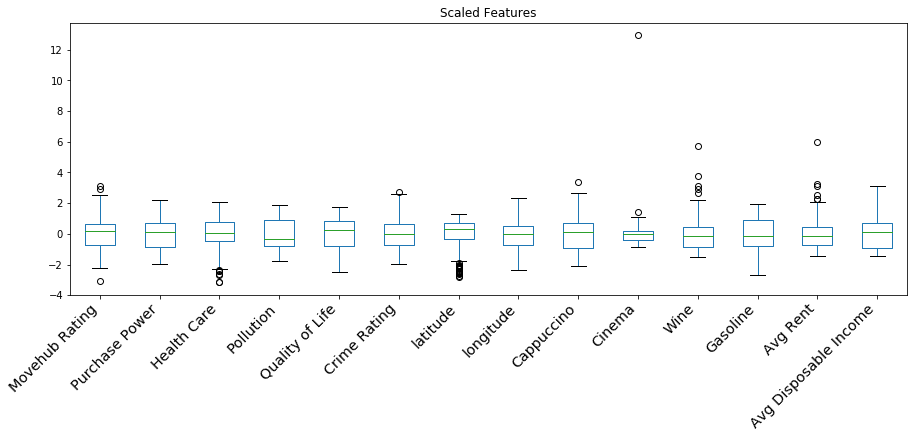

In [222]:
chart = scaled_df.plot.box(figsize=(15,5), title = 'Scaled Features')

chart.set_xticklabels(
    chart.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large')

plt.show()

As seen there are still lot of outliers present in the feature space even after standardizing and scaling the dataset. We need to get rif of such outliers in order for robust working of our machine learning algorithm.

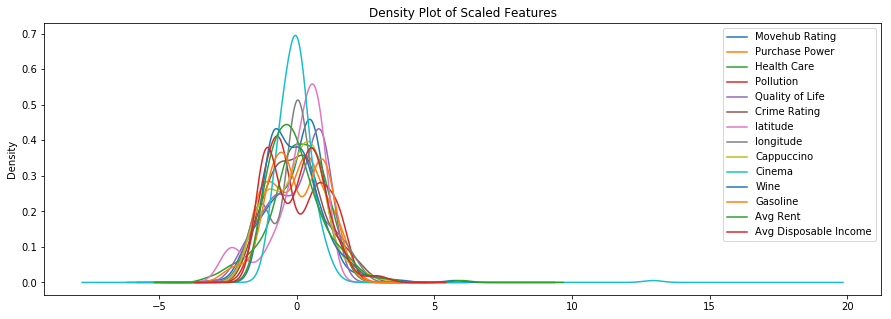

In [223]:
scaled_df.plot.density(figsize=(15,5), title = 'Density Plot of Scaled Features')
plt.show()

## Principal Component Analysis

Density plot of features confirms that some of the features are not normally distributed because of outliers present in the data. So using Principal Component Analysis for dimensionality reduction by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible

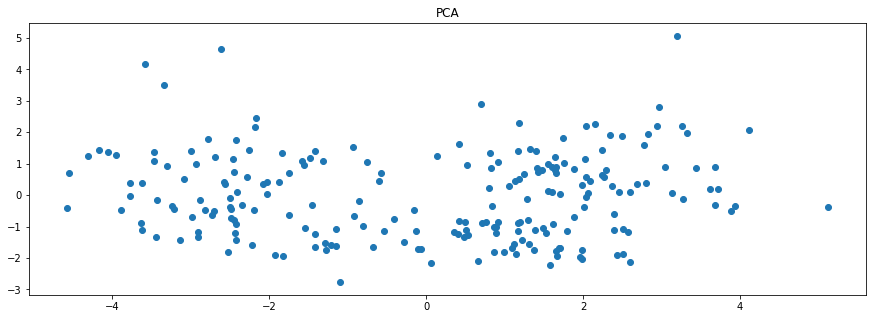

In [224]:
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(scaled_df)
pca_df = pd.DataFrame(data=pca_fit,columns=['A','B'])

plt.figure(figsize=(15,5))
plt.scatter(pca_df['A'],pca_df['B'])
plt.title('PCA')
plt.show()

Now checking for correlation by applying PCA. Above graph confirms there is no presence of correaltion between two principal components generated

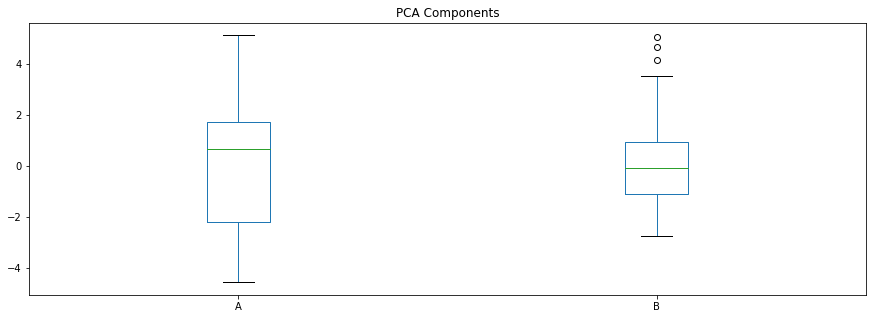

In [225]:
pca_df.plot.box(figsize=(15,5), title = 'PCA Components')
plt.show()

Thus outliers in the data has been considerabely reduced and thus the data can now be used to model appropriate machine learning algorithms

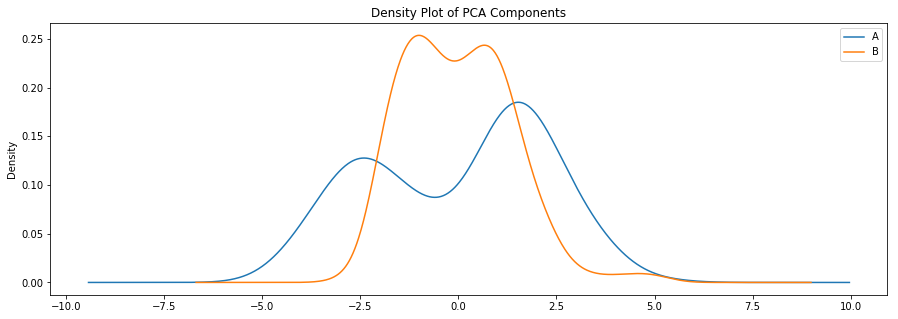

In [226]:
pdf.plot.density(figsize=(15,5), title = 'Density Plot of PCA Components')
plt.show()

Density plot also shows that data after applying PCA follows shape closely resembling normal distribution

## Model Building

Now Implementing K-means algorithm by choosing number of clusters as 3. 
Since in our tool in Tableau we have classified each feature in 3 categories to filter down the city names, we are also dividing city into 3 different groups so that interested users can identify city group which matches their criteria

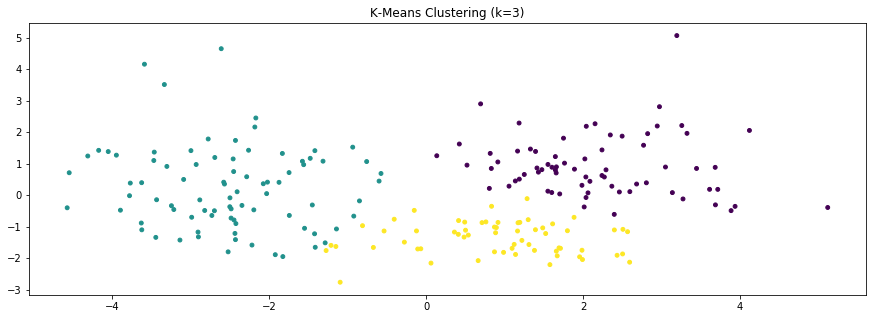

In [227]:
km = KMeans(init="k-means++", n_clusters=3, n_init=100)
km.fit(pca_df)
y_kmeans=km.predict(pca_df)

plt.figure(figsize=(15,5))

plt.scatter(pca_df['A'], pca_df['B'], c =y_kmeans, s=15)
plt.title('K-Means Clustering (k=3)')
plt.show()

3 distinct clusters can be seen on the data which is first standardized and then dimensionally reduced with the help of PCA

Standard normalization of data converts every column vector to the range [0,1] 

PCA is utilized to eliminate dimensions- number of components chosen as 2(dimensions).

In [228]:

labels = pd.DataFrame.from_dict(y_kmeans,dtype='float')
df = df.join(labels)
df = df.rename(columns={0:'labels'})
df = pd.DataFrame.from_dict(df)


Now we have inputted the results generated from clustering algorithms to the original dataset by generating above dataframe
and the calling the function as implemented below

In [229]:
def citygroupcolors(counter):
    if counter['labels'] == 1:
        return 'green'
    elif counter['labels'] == 0:
        return 'blue'
    elif counter['labels'] == 2:
        return 'red'
    else:
        return 'yellow'

df["color"] = df.apply(citygroupcolors, axis=1)
    


### Using folium to represent clusters in which city belongs

In [231]:

map_cluster = folium.Map(location = [my_latitude,my_longitude], fill_color='YlGn', zoom_start=2)

folium.Marker([my_latitude,my_longitude], tooltip='College Station').add_to(map_cluster)
                
# Add markers to map
for lat, lon, colors in zip(df['latitude'], df['longitude'], df['color']):
    
    folium.CircleMarker([lat,lon],
                        radius = 4,
                        Popup = label,
                        color = colors
                        ).add_to(map_cluster)
    
map_cluster



Thus from the above graph we can see the clusters city belong to. Our model has done nice work in grouping the cities as city in same country is likely having similar characterstic. We can see a lot of variability around Europe which is hub for many people so likely to have different categories of cities present. One can dig more further to select a criteria for his search and then explore similar option by looking at the cluster to which the city belongs and thus have more options when it comes to relocation for job, education or any other purpose

# Thank You!

Please also have a look at our Tableau dashboard to search for cities based on your specific criteria